# Stress Detection from Audio Data


### Project Overview
This notebook implements stress detection from audio data following the CRISP-DM methodology.

#### Required Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

### 1. Data Understanding & EDA

##### 1.1 Load the Dataset


### Uploaded Dataset can be found at https://drive.google.com/drive/folders/134E0rWv5Wmiihhl_3ipdRzV-Zh8eeNaW?usp=sharing

In [ ]:
base_dir = "/content/drive/MyDrive/stress detection audio"

# Dictionary to map folder names to labels
emotion_map = {
    "anger": "stressed",
    "fear": "stressed",
    "disgust": "not_stressed",
    "happiness": "not_stressed",
    "sadness": "not_stressed"
}

# Initialize lists to store data
data = []
labels = []

# Loop through each folder and file
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file.endswith(".wav"):
                label = emotion_map[folder]
                data.append(file_path)
                labels.append(label)

df = pd.DataFrame({"file_path": data, "label": labels})
df.head()

,file_path,label
0,/content/drive/MyDrive/stress detection audio/...,not_stressed
1,/content/drive/MyDrive/stress detection audio/...,not_stressed
2,/content/drive/MyDrive/stress detection audio/...,not_stressed
3,/content/drive/MyDrive/stress detection audio/...,not_stressed
4,/content/drive/MyDrive/stress detection audio/...,not_stressed


#### 1.2 Analyze Data Distribution

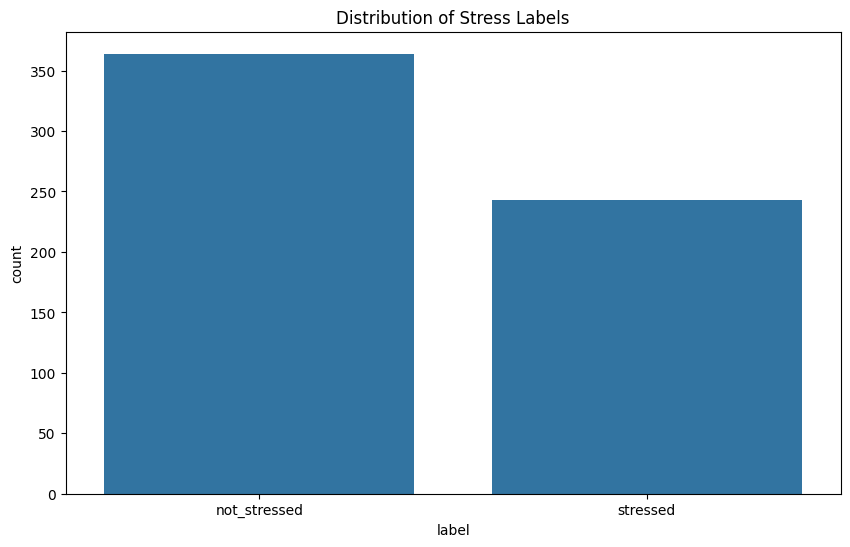

In [ ]:
# Plot distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(x="label", data=df)
plt.title("Distribution of Stress Labels")
plt.show()

#### 1.3 Analyze Audio Durations

Error loading /content/drive/MyDrive/stress detection audio/sadness/s05 (3).wav: 


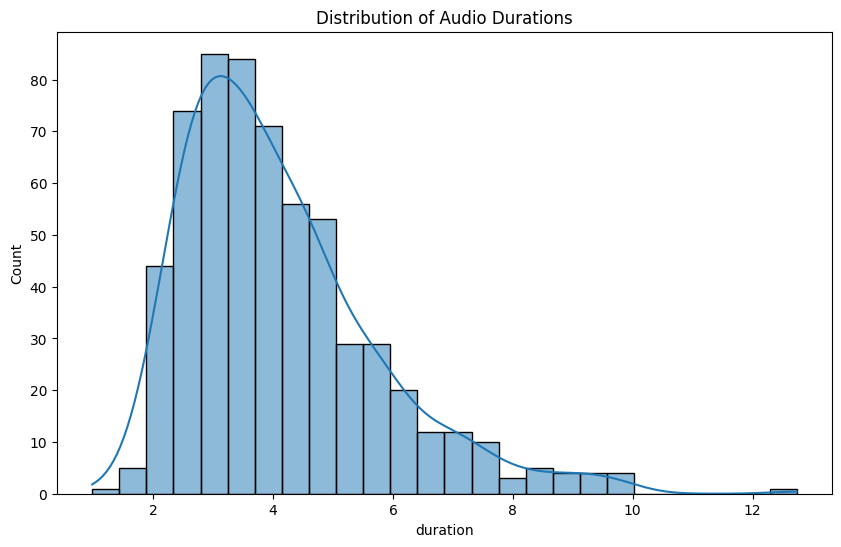

In [ ]:
durations = []
for file_path in df['file_path']:
    try:
        y, sr = librosa.load(file_path)
        duration = librosa.get_duration(y=y, sr=sr)
        durations.append(duration)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        durations.append(None)

df['duration'] = durations
df = df.dropna(subset=['duration'])

# Plot duration distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], kde=True)
plt.title("Distribution of Audio Durations")
plt.show()

#### 1.4 Feature Analysis

In [ ]:
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=2.5, offset=0.6)
        features = []

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features.extend(np.mean(mfccs.T, axis=0))

        # Chroma feature
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features.extend(np.mean(chroma.T, axis=0))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features.extend(np.mean(zcr.T, axis=0))

        # Spectral roll-off, centroid, bandwidth
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        features.extend(np.mean(rolloff.T, axis=0))

        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features.extend(np.mean(centroid.T, axis=0))

        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        features.extend(np.mean(bandwidth.T, axis=0))

        return np.array(features)
    except:
        return None

# Extract features and remove invalid entries
df['features'] = df['file_path'].apply(extract_features)
df = df.dropna(subset=['features'])
X = np.array(df['features'].tolist())
y = df['label'].apply(lambda x: 1 if x == "stressed" else 0).values

### 2. Data Preprocessing

#### 2.1 Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Basic Model Implementation


#### 3.1 Simple Neural Network Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#### 3.2 Train Model

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4993 - loss: 5.8761 - val_accuracy: 0.6186 - val_loss: 1.6305
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5887 - loss: 2.9948 - val_accuracy: 0.4021 - val_loss: 7.8552
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5845 - loss: 4.9973 - val_accuracy: 0.6082 - val_loss: 3.4599
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6459 - loss: 2.0534 - val_accuracy: 0.6186 - val_loss: 1.9631
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5526 - loss: 2.9452 - val_accuracy: 0.6804 - val_loss: 1.5810
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6155 - loss: 2.6858 - val_accuracy: 0.5464 - val_loss: 1.9259
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6327 - loss: 2.6536 - val_accuracy: 0.5773 - val_loss: 5.5938
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6165 - loss: 2.0384 - val_accuracy: 0.5773 - val_loss:

#### 3.3 Evaluate Model

In [ ]:
# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        76
           1       0.00      0.00      0.00        46

    accuracy                           0.62       122
   macro avg       0.31      0.50      0.38       122
weighted avg       0.39      0.62      0.48       122


Confusion Matrix:
[[76  0]
 [46  0]]


#### 3.4 Plot Training History


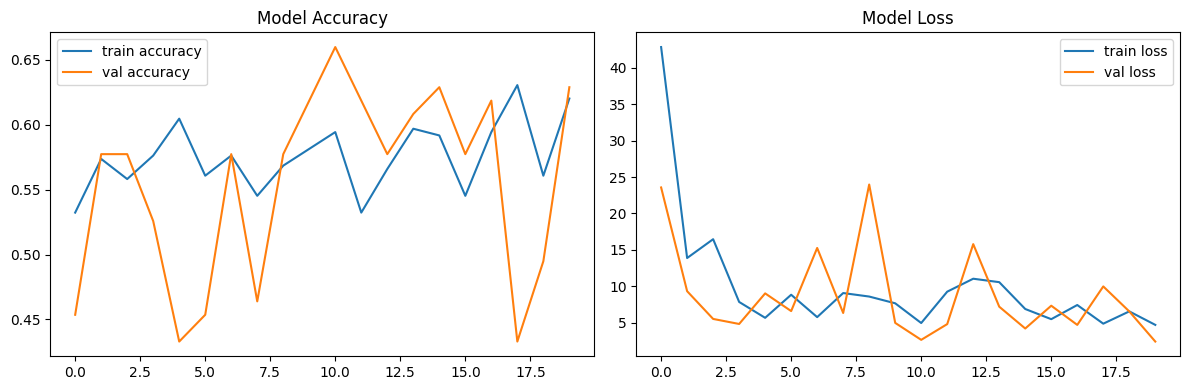

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title("Model Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model Loss")

plt.tight_layout()
plt.show()

## 4. Advanced Model Implementation

#### 4.1 Enhanced Feature Extraction

In [ ]:
def extract_advanced_features(y, sr):
    """Extract comprehensive audio features"""
    features = {}

    # Time-domain features
    features['raw_signal'] = y
    features['mfcc'] = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    features['mel_spec'] = librosa.feature.melspectrogram(y=y, sr=sr)
    features['chroma'] = librosa.feature.chroma_stft(y=y, sr=sr)
    features['spectral_contrast'] = librosa.feature.spectral_contrast(y=y, sr=sr)
    features['tonnetz'] = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

    return features

# Process files with advanced features
advanced_features = []
for file_path in df['file_path']:
    try:
        y, sr = librosa.load(file_path, duration=2.0)
        features = extract_advanced_features(y, sr)
        if features is not None:
            advanced_features.append(features)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

### 4.2 Advanced Model Architecture

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D,BatchNormalization,MaxPooling1D,Dropout,Bidirectional,LSTM,Dense,Flatten
from tensorflow.keras.models import Model


def build_advanced_model(input_shape):
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(64, 5, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    # Attention mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = tf.keras.layers.Softmax()(attention)
    x = tf.keras.layers.Multiply()([x, attention])

    # LSTM layers
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.5)(x)
    x = Bidirectional(LSTM(32))(x)
    x = Dropout(0.5)(x)

    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

# Build and compile advanced model
advanced_model = build_advanced_model((X_train.shape[1], 1))
advanced_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

### 4.3 Train Advanced Model

In [ ]:
# Training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Train model
advanced_history = advanced_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.5044 - auc: 0.4914 - loss: 1.0045 - val_accuracy: 0.5773 - val_auc: 0.5255 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5523 - auc: 0.5641 - loss: 0.8279 - val_accuracy: 0.5773 - val_auc: 0.5115 - val_loss: 0.6826 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5263 - auc: 0.5194 - loss: 0.8727 - val_accuracy: 0.5773 - val_auc: 0.5266 - val_loss: 0.6819 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5042 - auc: 0.5129 - loss: 0.8718 - val_accuracy: 0.5773 - val_auc: 0.5370 - val_loss: 0.6800 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5401 - auc: 0.5359 - loss: 0.8419 - val_accuracy: 0.5773 - val_auc: 0.5510 - val_loss: 0.6787 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5262 - auc: 0.5205 

### 4.4 Evaluate Advanced Model

In [ ]:
# Predict and evaluate
y_pred_advanced = (advanced_model.predict(X_test) > 0.5).astype(int)

print("\nAdvanced Model Classification Report:")
print(classification_report(y_test, y_pred_advanced))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_advanced))



4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step

Advanced Model Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        76
           1       0.00      0.00      0.00        46

    accuracy                           0.62       122
   macro avg       0.31      0.50      0.38       122
weighted avg       0.39      0.62      0.48       122


Confusion Matrix:
[[76  0]
 [46  0]]


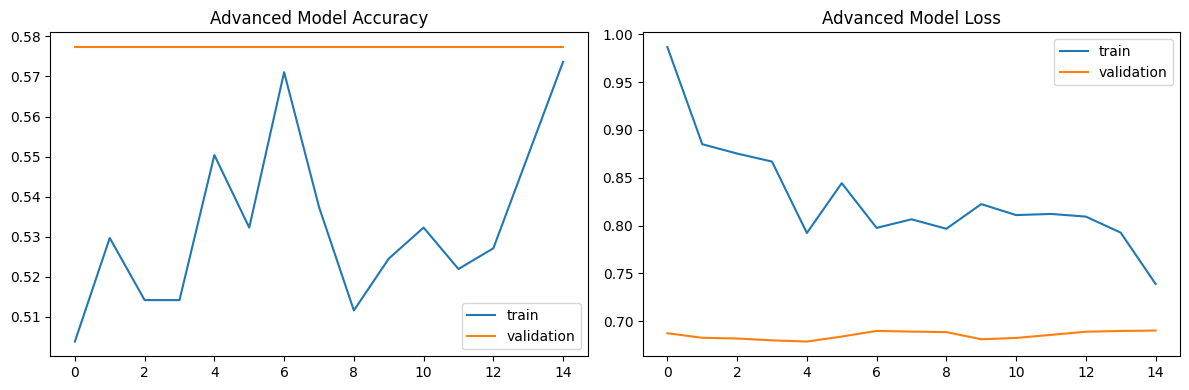

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(advanced_history.history['accuracy'], label='train')
plt.plot(advanced_history.history['val_accuracy'], label='validation')
plt.title('Advanced Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(advanced_history.history['loss'], label='train')
plt.plot(advanced_history.history['val_loss'], label='validation')
plt.title('Advanced Model Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 5. Model Comparison and Analysis

In [ ]:
# Compare model performances
models = {
    'Basic Model': {
        'accuracy': history.history['val_accuracy'][-1],
        'loss': history.history['val_loss'][-1]
    },
    'Advanced Model': {
        'accuracy': advanced_history.history['val_accuracy'][-1],
        'loss': advanced_history.history['val_loss'][-1]
    }
}

comparison_df = pd.DataFrame(models).T
print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
                accuracy       loss
Basic Model      0.57732  11.333939
Advanced Model   0.57732   0.690209


## Cutomizing Sequantial Layer

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# Dictionary to map folder names to labels
emotion_map = {
    "anger": "stressed",
    "fear": "stressed",
    "disgust": "not_stressed",
    "happiness": "not_stressed",
    "sadness": "not_stressed"
}

# Initialize lists to store data
data = []
labels = []

# Loop through each folder and file
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if file.endswith(".wav"):  # Assuming audio files are in .wav format
                label = emotion_map[folder]  # Map folder name to label
                data.append(file_path)
                labels.append(label)

df = pd.DataFrame({"file_path": data, "label": labels})


import numpy as np

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, duration=2.5, offset=0.6)
        features = []

        # Extract MFCCs(Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        features.extend(np.mean(mfccs.T, axis=0))

        # Chroma feature
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        features.extend(np.mean(chroma.T, axis=0))

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)
        features.extend(np.mean(zcr.T, axis=0))

        # Spectral roll-off, centroid, bandwidth
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        features.extend(np.mean(rolloff.T, axis=0))

        centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        features.extend(np.mean(centroid.T, axis=0))

        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        features.extend(np.mean(bandwidth.T, axis=0))

        return np.array(features)
    except:
        return None

# Apply feature extraction and remove rows with None features
df['features'] = df['file_path'].apply(extract_features)

# Ensure there are no NaN values in the 'features' column after extraction
df = df.dropna(subset=['features'])

# Convert features column to array and ensure label consistency
X = np.array(df['features'].tolist())
y = df['label'].apply(lambda x: 1 if x == "stressed" else 0).values

# Now perform the train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.4891 - loss: 36.0956 - val_accuracy: 0.4433 - val_loss: 7.1075
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5638 - loss: 5.4269 - val_accuracy: 0.6701 - val_loss: 1.9043
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4983 - loss: 8.8751 - val_accuracy: 0.5979 - val_loss: 5.1966
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6148 - loss: 2.9247 - val_accuracy: 0.5773 - val_loss: 5.8290
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5235 - loss: 4.0548 - val_accuracy: 0.5773 - val_loss: 5.4341
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5205 - loss: 4.3443 - val_accuracy: 0.4330 - val_loss: 8.2205
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4943 - loss: 7.3155 - val_accuracy: 0.5773 - val_loss: 16.4712
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5717 - loss: 8.3566 - val_accuracy: 0.5773 - val_lo

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step
              precision    recall  f1-score   support

           0       0.66      1.00      0.80        76
           1       1.00      0.15      0.26        46

    accuracy                           0.68       122
   macro avg       0.83      0.58      0.53       122
weighted avg       0.79      0.68      0.60       122

[[76  0]
 [39  7]]


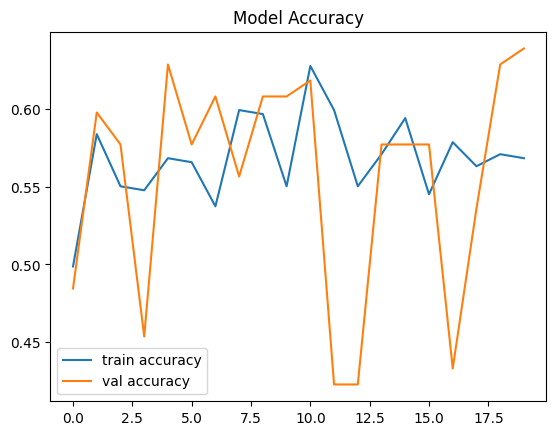

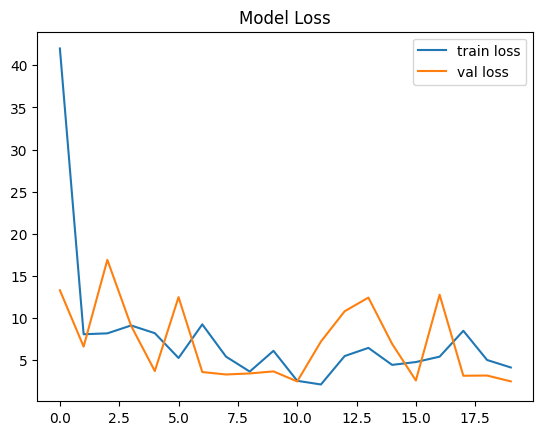

In [ ]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Model Loss")
plt.show()


## A standard LSTM (Long Short-Term Memory) model and A Bidirectional LSTM model

Starting Stress Detection Training Pipeline...

1. Loading and Preprocessing Data...
Loading and preprocessing data...
Processing anger files...


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Processed 120 files...
Finished anger: 123 processed, 0 failed
Processing fear files...
Processed 10 files...


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Processed 120 files...
Finished fear: 120 processed, 0 failed
Processing disgust files...
Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Processed 120 files...
Finished disgust: 122 processed, 0 failed
Processing happiness files...
Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Finished happiness: 119 processed, 0 failed
Processing sadness files...
Processed 10 files...
Processed 2

<ipython-input-11-838988beba5e>:85: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(


Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Processed 120 files...
Finished sadness: 122 processed, 1 failed

2. Data Validation:
Features shape: (606, 173, 87)
Labels shape: (606,)
Number of samples: 606
Class 0: 363 samples (59.90%)
Class 1: 243 samples (40.10%)

3. Training Models...

Training lstm model...
Building lstm model with input shape: (173, 87)
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.4675 - auc: 0.4980 - loss: 2.1345 - precision: 0.3477 - recall: 0.4995 - val_accuracy: 0.5773 - val_auc: 0.6132 - val_loss: 1.7580 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5469 - auc: 0.5700 - loss: 1.9902 - precision: 0.4606 - recall: 0.5300 - val_accuracy: 0.4948 - val_auc: 0.6803 - val_loss: 1.7614 - val_precision: 0.4524 - val_recall: 0.9268 - learning_ra

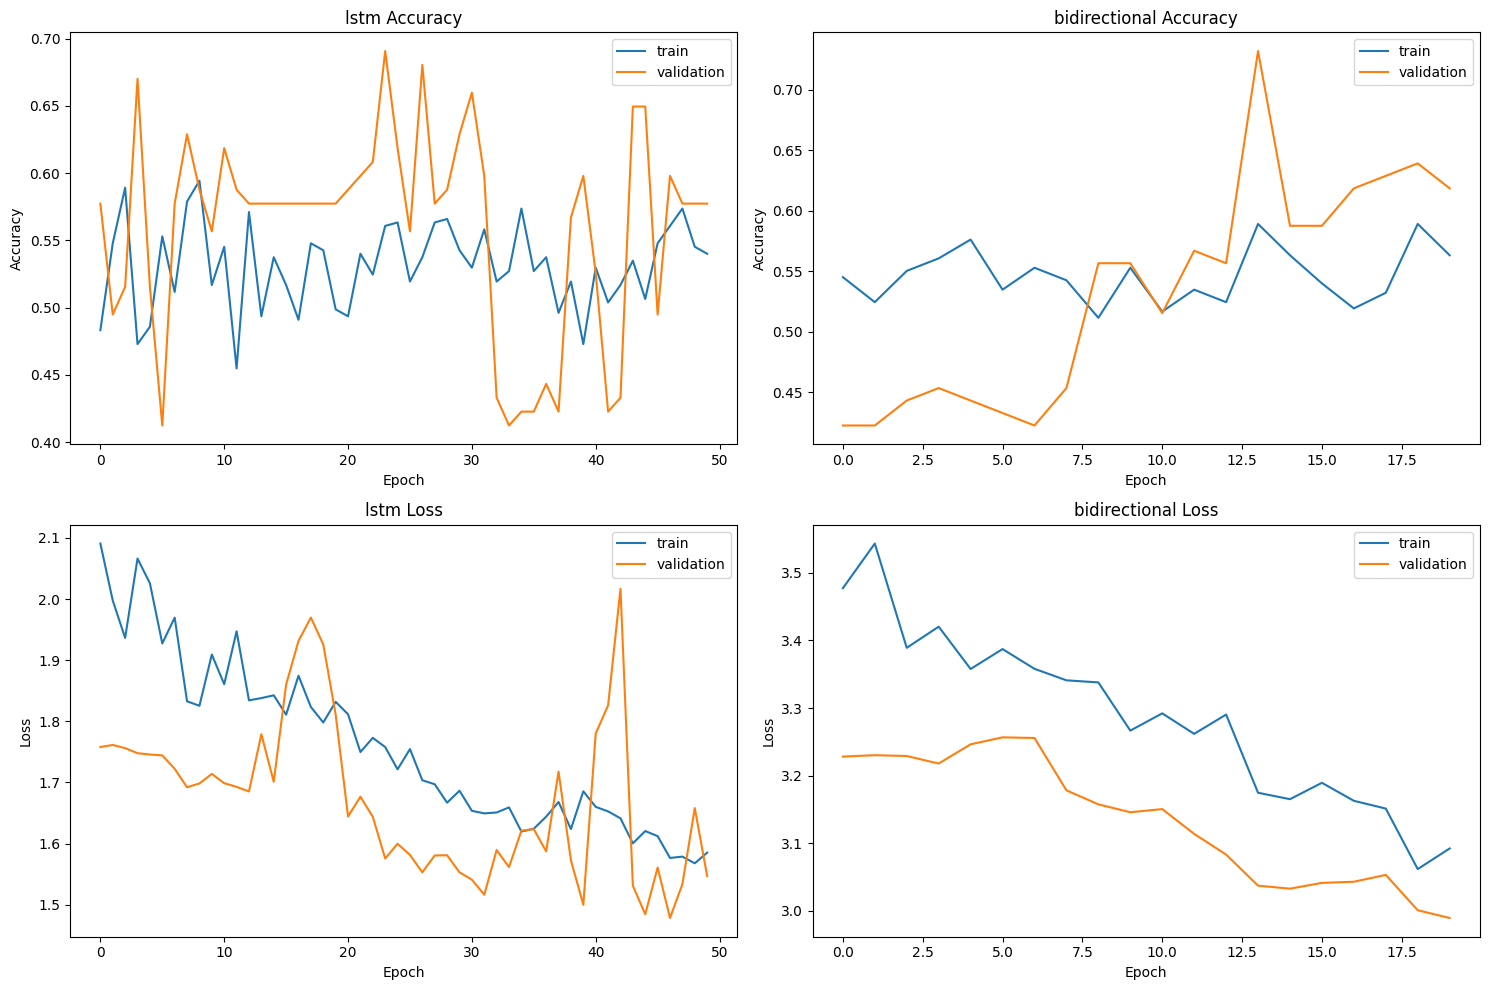


4. Results:

Model: lstm
Accuracy: 0.6066
Recall: 0.7551

Detailed Report:
              precision    recall  f1-score   support

           0       0.76      0.51      0.61        73
           1       0.51      0.76      0.61        49

    accuracy                           0.61       122
   macro avg       0.63      0.63      0.61       122
weighted avg       0.66      0.61      0.61       122


Model: bidirectional
Accuracy: 0.7213
Recall: 0.7755

Detailed Report:
              precision    recall  f1-score   support

           0       0.82      0.68      0.75        73
           1       0.62      0.78      0.69        49

    accuracy                           0.72       122
   macro avg       0.72      0.73      0.72       122
weighted avg       0.74      0.72      0.72       122



In [ ]:

import tensorflow as tf
import numpy as np
import librosa
import os
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D,
                                   Dropout, BatchNormalization, Input, ConvLSTM2D,
                                   Reshape, Flatten)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.regularizers import l2  # Add this import at the top


class EnhancedStressDetector:
    def __init__(self, base_dir="/content/drive/MyDrive/stress detection audio", sr=22050, duration=2.0):
        self.base_dir = base_dir
        self.sr = sr
        self.duration = duration
        self.models = {}

    def extract_features(self, y):
        """Extract audio features with improved processing."""
        if y is None or len(y) == 0:
            return None

        try:
            # Calculate target length
            target_length = int(self.sr * self.duration)

            # Pad or truncate the signal
            if len(y) > target_length:
                y = y[:target_length]
            else:
                y = np.pad(y, (0, max(0, target_length - len(y))))

            # Normalize audio
            y = librosa.util.normalize(y)

            features = {
                'mfcc': librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=20),
                'mel_spec': librosa.feature.melspectrogram(y=y, sr=self.sr),
                'chroma': librosa.feature.chroma_stft(y=y, sr=self.sr),
                'spectral_contrast': librosa.feature.spectral_contrast(y=y, sr=self.sr),
                'tonnetz': librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=self.sr)
            }

            # Concatenate and normalize features
            feature_matrix = np.concatenate([v for v in features.values()], axis=0)
            feature_matrix = (feature_matrix - np.mean(feature_matrix)) / (np.std(feature_matrix) + 1e-10)

            return feature_matrix

        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return None

    def load_and_preprocess_data(self):
        """Load and preprocess audio files with improved error handling."""
        features_list = []
        labels = []

        emotion_map = {
            'anger': 1,     # stressed
            'fear': 1,      # stressed
            'disgust': 0,   # not stressed
            'happiness': 0, # not stressed
            'sadness': 0    # not stressed
        }

        print("Loading and preprocessing data...")
        for emotion in emotion_map.keys():
            folder_path = os.path.join(self.base_dir, emotion)
            if os.path.exists(folder_path):
                print(f"Processing {emotion} files...")
                files_processed = 0
                files_failed = 0

                for file in os.listdir(folder_path):
                    if file.endswith('.wav'):
                        try:
                            file_path = os.path.join(folder_path, file)
                            y, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)

                            features = self.extract_features(y)
                            if features is not None:
                                features_list.append(features)
                                labels.append(emotion_map[emotion])
                                files_processed += 1

                                if files_processed % 10 == 0:
                                    print(f"Processed {files_processed} files...")
                            else:
                                files_failed += 1

                        except Exception as e:
                            print(f"Error processing {file}: {str(e)}")
                            files_failed += 1
                            continue

                print(f"Finished {emotion}: {files_processed} processed, {files_failed} failed")

        if len(features_list) == 0:
            raise ValueError("No features could be extracted from the audio files")

        return np.array(features_list), np.array(labels)

    def build_model(self, model_type, input_shape):
        """Enhanced model architecture with better regularization and capacity."""
        print(f"Building {model_type} model with input shape: {input_shape}")

        model = Sequential([
            Input(shape=input_shape),

            # First layer with stronger regularization
            Dropout(0.3),

            # Deeper architecture with fixed regularization
            *self._get_lstm_layers(model_type, 256, 0.001),
            BatchNormalization(),
            Dropout(0.4),

            *self._get_lstm_layers(model_type, 128, 0.001),
            BatchNormalization(),
            Dropout(0.4),

            *self._get_lstm_layers(model_type, 64, 0.001, return_sequences=False),
            BatchNormalization(),
            Dropout(0.3),

            # Wider dense layers
            Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.2),

            Dense(1, activation='sigmoid')
        ])

        return model

    def _get_lstm_layers(self, model_type, units, reg_factor, return_sequences=True):
        """Helper function to get LSTM layers based on model type."""
        if model_type == "lstm":
            return [LSTM(units,
                        return_sequences=return_sequences,
                        kernel_regularizer=tf.keras.regularizers.l2(reg_factor),
                        recurrent_regularizer=tf.keras.regularizers.l2(reg_factor/2),
                        activation='tanh',
                        recurrent_activation='sigmoid')]
        else:
            return [Bidirectional(LSTM(units,
                                     return_sequences=return_sequences,
                                     kernel_regularizer=tf.keras.regularizers.l2(reg_factor),
                                     recurrent_regularizer=tf.keras.regularizers.l2(reg_factor/2),
                                     activation='tanh',
                                     recurrent_activation='sigmoid'))]



    def train_models(self, X, y, epochs=50, batch_size=32):
        """Enhanced training with better preprocessing and monitoring."""
        # Standardize features
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

        # Compute class weights with stronger balancing
        class_counts = np.bincount(y)
        total = len(y)
        class_weights = {i: (total / (len(np.unique(y)) * count)) * 1.2
                        if i == 1 else (total / (len(np.unique(y)) * count))
                        for i, count in enumerate(class_counts)}

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        from tensorflow.keras.optimizers import Adam
        from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
        # Enhanced callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True,
                mode='min'
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=10,
                min_lr=1e-6,
                mode='min'
            )
        ]

        results = {}
        histories = {}

        for model_type in ["lstm", "bidirectional"]:
            print(f"\nTraining {model_type} model...")
            try:
                model = self.build_model(model_type, (X_train.shape[1], X_train.shape[2]))

                model.compile(
                    optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
                    loss='binary_crossentropy',
                    metrics=['accuracy',
                            tf.keras.metrics.Recall(name='recall'),
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.AUC(name='auc')]
                )

                history = model.fit(
                    X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.2,
                    callbacks=callbacks,
                    class_weight=class_weights,
                    verbose=1
                )

                self.models[model_type] = model
                histories[model_type] = history
                results[model_type] = self.evaluate_model(model, X_test, y_test)

            except Exception as e:
                print(f"Error training {model_type} model: {str(e)}")
                import traceback
                print(traceback.format_exc())
                continue

        if histories:
            self.plot_training_histories(histories)
        return results

    def evaluate_model(self, model, X_test, y_test):
        """Enhanced evaluation with threshold optimization."""
        # Get raw predictions
        y_pred_proba = model.predict(X_test)

        # Find optimal threshold
        thresholds = np.arange(0.3, 0.7, 0.05)
        best_threshold = 0.5
        best_f1 = 0

        for threshold in thresholds:
            y_pred = (y_pred_proba > threshold).astype(int)
            precision = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        # Final predictions with optimal threshold
        y_pred = (y_pred_proba > best_threshold).astype(int)

        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'threshold': best_threshold,
            'report': classification_report(y_test, y_pred)
        }

    def plot_training_histories(self, histories):
        """Plot training metrics."""
        fig, axes = plt.subplots(2, len(histories), figsize=(15, 10))

        for idx, (model_name, history) in enumerate(histories.items()):
            # Accuracy
            axes[0, idx].plot(history.history['accuracy'], label='train')
            axes[0, idx].plot(history.history['val_accuracy'], label='validation')
            axes[0, idx].set_title(f'{model_name} Accuracy')
            axes[0, idx].set_xlabel('Epoch')
            axes[0, idx].set_ylabel('Accuracy')
            axes[0, idx].legend()

            # Loss
            axes[1, idx].plot(history.history['loss'], label='train')
            axes[1, idx].plot(history.history['val_loss'], label='validation')
            axes[1, idx].set_title(f'{model_name} Loss')
            axes[1, idx].set_xlabel('Epoch')
            axes[1, idx].set_ylabel('Loss')
            axes[1, idx].legend()

        plt.tight_layout()
        plt.show()

def main():
    try:
        print("Starting Stress Detection Training Pipeline...")
        print("=" * 50)

        # Initialize detector
        detector = EnhancedStressDetector(base_dir="/content/drive/MyDrive/stress detection audio")

        # Load and preprocess data
        print("\n1. Loading and Preprocessing Data...")
        X, y = detector.load_and_preprocess_data()

        # Data validation
        print("\n2. Data Validation:")
        print(f"Features shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        print(f"Number of samples: {len(X)}")

        unique_classes, counts = np.unique(y, return_counts=True)
        for cls, count in zip(unique_classes, counts):
            print(f"Class {cls}: {count} samples ({count/len(y)*100:.2f}%)")

        # Train models
        print("\n3. Training Models...")
        results = detector.train_models(X, y, epochs=50, batch_size=32)

        # Print results
        print("\n4. Results:")
        for model_name, metrics in results.items():
            print(f"\nModel: {model_name}")
            print("=" * 30)
            print(f"Accuracy: {metrics['accuracy']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print("\nDetailed Report:")
            print(metrics['report'])

    except Exception as e:
        print(f"\nError: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


## Bidirectional Model with complex model architecture with increased LSTM units (512, 256, 128)

Starting Stress Detection Training Pipeline...

1. Loading and Preprocessing Data...
Loading and preprocessing data...
Processing anger files...
Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Processed 120 files...
Finished anger: 123 processed, 0 failed
Processing fear files...
Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 files...
Processed 100 files...
Processed 110 files...
Processed 120 files...
Finished fear: 120 processed, 0 failed
Processing disgust files...
Processed 10 files...
Processed 20 files...
Processed 30 files...
Processed 40 files...
Processed 50 files...
Processed 60 files...
Processed 70 files...
Processed 80 files...
Processed 90 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)                  │ (None, 173, 87)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 173, 1024)           │       2,457,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 173, 1024)           │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 173, 1024)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 173, 512)            │       2,623,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 173, 512)            │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 173, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,844,993 (22.30 MB)

 Trainable params: 5,840,641 (22.28 MB)

 Non-trainable params: 4,352 (17.00 KB)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.4764 - auc_1: 0.4787 - loss: 9.7754 - precision: 0.3772 - recall: 0.4611 - val_accuracy: 0.5773 - val_auc_1: 0.5531 - val_loss: 6.3216 - val_precision: 0.5000 - val_recall: 0.0488 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5127 - auc_1: 0.5372 - loss: 9.4188 - precision: 0.4303 - recall: 0.5888 - val_accuracy: 0.5464 - val_auc_1: 0.5499 - val_loss: 6.4812 - val_precision: 0.4571 - val_recall: 0.3902 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.5366 - auc_1: 0.5536 - loss: 9.0762 - precision: 0.4085 - recall: 0.5997 - val_accuracy: 0.4948 - val_auc_1: 0.5292 - val_loss: 6.5113 - val_precision: 0.3889 - val_recall: 0.3415 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.5537 - auc_1: 0.6039 - loss: 8.8516 - precision: 0.4379 - recall: 0.6580 - val_accuracy: 0.5773 - val_auc_1: 0.5000 - val_l

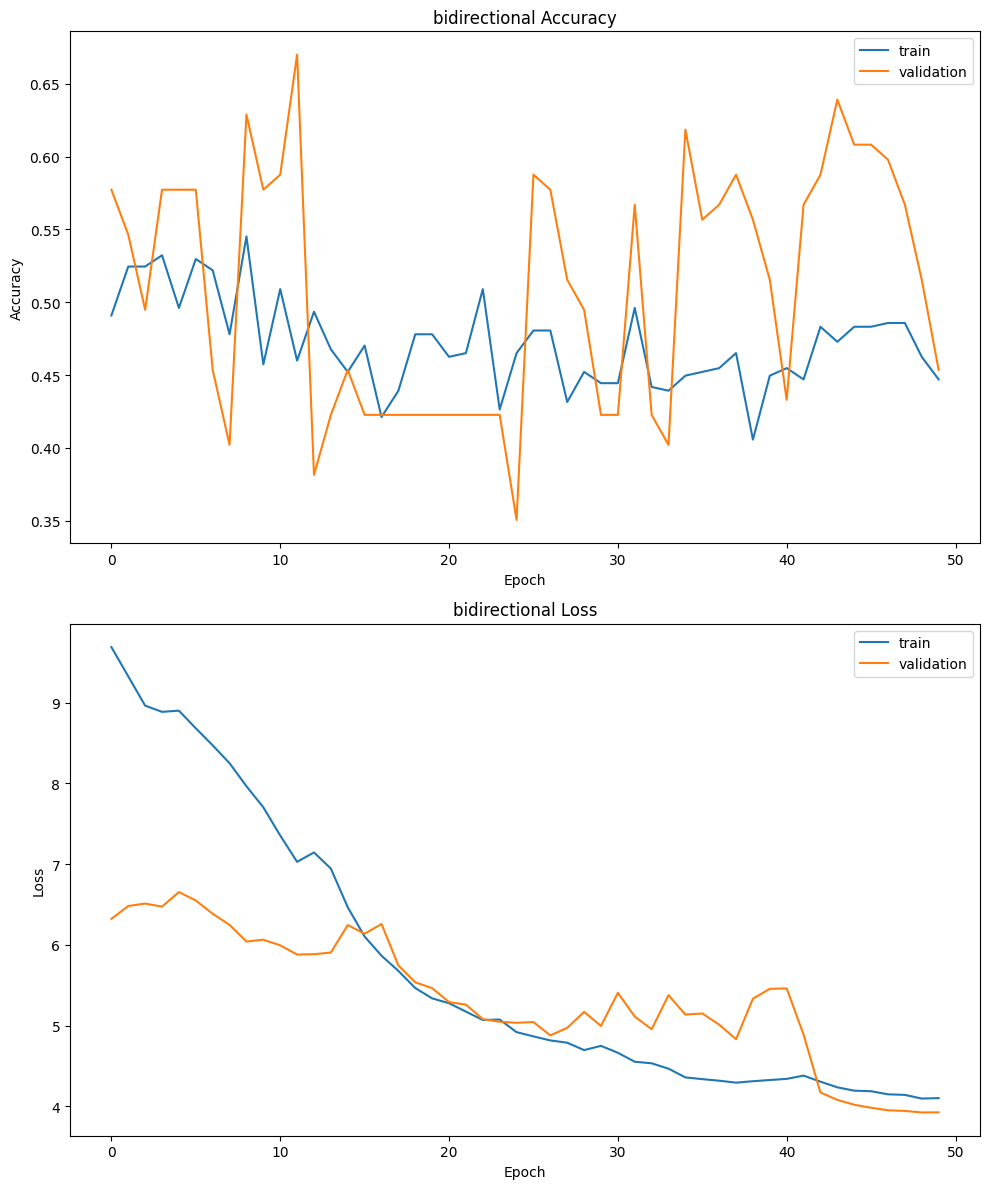


4. Results:

Model: bidirectional
Accuracy: 0.4918
Recall: 0.9592

Detailed Report:
              precision    recall  f1-score   support

           0       0.87      0.18      0.30        73
           1       0.44      0.96      0.60        49

    accuracy                           0.49       122
   macro avg       0.65      0.57      0.45       122
weighted avg       0.70      0.49      0.42       122



In [ ]:

import tensorflow as tf
import numpy as np
import librosa
import os
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, Bidirectional, Conv1D, MaxPooling1D,
                                   Dropout, BatchNormalization, Input, ConvLSTM2D,
                                   Reshape, Flatten)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.regularizers import l2  # Add this import at the top


class EnhancedStressDetector:
    def __init__(self, base_dir="/content/drive/MyDrive/stress detection audio", sr=22050, duration=2.0):
        self.base_dir = base_dir
        self.sr = sr
        self.duration = duration
        self.models = {}

    def extract_features(self, y):
        """Extract audio features with improved processing."""
        if y is None or len(y) == 0:
            return None

        try:
            # Calculate target length
            target_length = int(self.sr * self.duration)

            # Pad or truncate the signal
            if len(y) > target_length:
                y = y[:target_length]
            else:
                y = np.pad(y, (0, max(0, target_length - len(y))))

            # Normalize audio
            y = librosa.util.normalize(y)

            features = {
                'mfcc': librosa.feature.mfcc(y=y, sr=self.sr, n_mfcc=20),
                'mel_spec': librosa.feature.melspectrogram(y=y, sr=self.sr),
                'chroma': librosa.feature.chroma_stft(y=y, sr=self.sr),
                'spectral_contrast': librosa.feature.spectral_contrast(y=y, sr=self.sr),
                'tonnetz': librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=self.sr)
            }

            # Concatenate and normalize features
            feature_matrix = np.concatenate([v for v in features.values()], axis=0)
            feature_matrix = (feature_matrix - np.mean(feature_matrix)) / (np.std(feature_matrix) + 1e-10)

            return feature_matrix

        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return None

    def load_and_preprocess_data(self):
        """Load and preprocess audio files with improved error handling."""
        features_list = []
        labels = []

        emotion_map = {
            'anger': 1,     # stressed
            'fear': 1,      # stressed
            'disgust': 0,   # not stressed
            'happiness': 0, # not stressed
            'sadness': 0    # not stressed
        }

        print("Loading and preprocessing data...")
        for emotion in emotion_map.keys():
            folder_path = os.path.join(self.base_dir, emotion)
            if os.path.exists(folder_path):
                print(f"Processing {emotion} files...")
                files_processed = 0
                files_failed = 0

                for file in os.listdir(folder_path):
                    if file.endswith('.wav'):
                        try:
                            file_path = os.path.join(folder_path, file)
                            y, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)

                            features = self.extract_features(y)
                            if features is not None:
                                features_list.append(features)
                                labels.append(emotion_map[emotion])
                                files_processed += 1

                                if files_processed % 10 == 0:
                                    print(f"Processed {files_processed} files...")
                            else:
                                files_failed += 1

                        except Exception as e:
                            print(f"Error processing {file}: {str(e)}")
                            files_failed += 1
                            continue

                print(f"Finished {emotion}: {files_processed} processed, {files_failed} failed")

        if len(features_list) == 0:
            raise ValueError("No features could be extracted from the audio files")

        return np.array(features_list), np.array(labels)


    def build_model(self, model_type, input_shape):
        """Optimized model architecture based on results."""
        print(f"Building {model_type} model with input shape: {input_shape}")

        model = Sequential([
            Input(shape=input_shape),

            # Increased initial dropout to prevent overfitting
            Dropout(0.3),

            # First layer with increased units
            *self._get_lstm_layers(model_type, 512, 0.001),
            BatchNormalization(),
            Dropout(0.4),

            # Second layer with optimized units
            *self._get_lstm_layers(model_type, 256, 0.001),
            BatchNormalization(),
            Dropout(0.4),

            # Third layer with reduced units
            *self._get_lstm_layers(model_type, 128, 0.001, return_sequences=False),
            BatchNormalization(),
            Dropout(0.3),

            # Wider dense layers with stronger regularization
            Dense(256, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                  activity_regularizer=tf.keras.regularizers.l1(0.001)),
            BatchNormalization(),
            Dropout(0.3),

            Dense(128, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.2),

            Dense(1, activation='sigmoid')
        ])

        return model

    def _get_lstm_layers(self, model_type, units, reg_factor, return_sequences=True):
        """Helper function to get LSTM layers based on model type."""
        if model_type == "lstm":
            return [LSTM(units,
                        return_sequences=return_sequences,
                        kernel_regularizer=tf.keras.regularizers.l2(reg_factor),
                        recurrent_regularizer=tf.keras.regularizers.l2(reg_factor/2),
                        activation='tanh',
                        recurrent_activation='sigmoid')]
        else:
            return [Bidirectional(LSTM(units,
                                     return_sequences=return_sequences,
                                     kernel_regularizer=tf.keras.regularizers.l2(reg_factor),
                                     recurrent_regularizer=tf.keras.regularizers.l2(reg_factor/2),
                                     activation='tanh',
                                     recurrent_activation='sigmoid'))]



    def train_models(self, X, y, epochs=50, batch_size=32):
        """Enhanced training with optimized parameters."""
        # Standardize features
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

        # Enhanced class weights with focus on minority class
        class_counts = np.bincount(y)
        total = len(y)
        class_weights = {
            i: (total / (len(np.unique(y)) * count)) * 1.5 if count < total/2
            else total / (len(np.unique(y)) * count)
            for i, count in enumerate(class_counts)
        }

        # Print class weights for verification
        print("\nClass weights:")
        for cls, weight in class_weights.items():
            print(f"Class {cls}: {weight:.4f}")

        # Split with stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                mode='min'
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=8,
                min_lr=1e-6,
                mode='min'
            )
        ]

        results = {}
        histories = {}

        try:
            # Train Bidirectional model
            print("\nTraining bidirectional model...")
            model = self.build_model("bidirectional", (X_train.shape[1], X_train.shape[2]))

            # Print model summary
            print("\nModel Architecture:")
            model.summary()

            model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
                loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),
                metrics=['accuracy',
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.AUC()]
            )

            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                callbacks=callbacks,
                class_weight=class_weights,
                verbose=1
            )

            self.models['bidirectional'] = model
            histories['bidirectional'] = history

            # Evaluate model
            y_pred = (model.predict(X_test) > 0.5).astype(int)
            results['bidirectional'] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'report': classification_report(y_test, y_pred),
                'confusion_matrix': confusion_matrix(y_test, y_pred)
            }

            # Print confusion matrix
            print("\nConfusion Matrix:")
            print(results['bidirectional']['confusion_matrix'])

        except Exception as e:
            print(f"Error training model: {str(e)}")
            import traceback
            print(traceback.format_exc())

        if histories:
            self.plot_training_histories(histories)
        return results

    def evaluate_model(self, model, X_test, y_test):
        """Enhanced evaluation with threshold optimization."""
        # Get raw predictions
        from sklearn.metrics import accuracy_score, recall_score, classification_report
        y_pred_proba = model.predict(X_test)

        # Find optimal threshold
        thresholds = np.arange(0.3, 0.7, 0.05)
        best_threshold = 0.5
        best_f1 = 0

        for threshold in thresholds:
            y_pred = (y_pred_proba > threshold).astype(int)
            precision = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        # Final predictions with optimal threshold
        y_pred = (y_pred_proba > best_threshold).astype(int)

        return {
            'accuracy': accuracy_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'threshold': best_threshold,
            'report': classification_report(y_test, y_pred)
        }

    def plot_training_histories(self, histories):
        """Plot training histories with flexible layout."""
        from sklearn.metrics import confusion_matrix
        import matplotlib.pyplot as plt
        num_models = len(histories)
        if num_models == 0:
            return

        # Create subplots based on number of models
        if num_models == 1:
            fig, axes = plt.subplots(2, 1, figsize=(10, 12))
            axes = axes.reshape(-1)  # Make it 1D
        else:
            fig, axes = plt.subplots(2, num_models, figsize=(15, 10))

        for idx, (model_name, history) in enumerate(histories.items()):
            if num_models == 1:
                # Plot accuracy
                axes[0].plot(history.history['accuracy'], label='train')
                axes[0].plot(history.history['val_accuracy'], label='validation')
                axes[0].set_title(f'{model_name} Accuracy')
                axes[0].set_xlabel('Epoch')
                axes[0].set_ylabel('Accuracy')
                axes[0].legend()

                # Plot loss
                axes[1].plot(history.history['loss'], label='train')
                axes[1].plot(history.history['val_loss'], label='validation')
                axes[1].set_title(f'{model_name} Loss')
                axes[1].set_xlabel('Epoch')
                axes[1].set_ylabel('Loss')
                axes[1].legend()
            else:
                # Plot accuracy
                axes[0, idx].plot(history.history['accuracy'], label='train')
                axes[0, idx].plot(history.history['val_accuracy'], label='validation')
                axes[0, idx].set_title(f'{model_name} Accuracy')
                axes[0, idx].set_xlabel('Epoch')
                axes[0, idx].set_ylabel('Accuracy')
                axes[0, idx].legend()

                # Plot loss
                axes[1, idx].plot(history.history['loss'], label='train')
                axes[1, idx].plot(history.history['val_loss'], label='validation')
                axes[1, idx].set_title(f'{model_name} Loss')
                axes[1, idx].set_xlabel('Epoch')
                axes[1, idx].set_ylabel('Loss')
                axes[1, idx].legend()

        plt.tight_layout()
        plt.show()

def main():
    try:
        print("Starting Stress Detection Training Pipeline...")
        print("=" * 50)

        # Initialize detector
        detector = EnhancedStressDetector(base_dir="/content/drive/MyDrive/stress detection audio")

        # Load and preprocess data
        print("\n1. Loading and Preprocessing Data...")
        X, y = detector.load_and_preprocess_data()

        # Data validation
        print("\n2. Data Validation:")
        print(f"Features shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        print(f"Number of samples: {len(X)}")

        unique_classes, counts = np.unique(y, return_counts=True)
        for cls, count in zip(unique_classes, counts):
            print(f"Class {cls}: {count} samples ({count/len(y)*100:.2f}%)")

        # Train models
        print("\n3. Training Models...")
        results = detector.train_models(X, y, epochs=50, batch_size=32)

        # Print results
        print("\n4. Results:")
        for model_name, metrics in results.items():
            print(f"\nModel: {model_name}")
            print("=" * 30)
            print(f"Accuracy: {metrics['accuracy']:.4f}")
            print(f"Recall: {metrics['recall']:.4f}")
            print("\nDetailed Report:")
            print(metrics['report'])

    except Exception as e:
        print(f"\nError: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


## ConvLSTM (Convolutional Long Short-Term Memory)

Loading and preprocessing data...
Processing anger files...
Processed 10 files from anger
Processed 20 files from anger
Processed 30 files from anger
Processed 40 files from anger
Processed 50 files from anger
Processed 60 files from anger
Processed 70 files from anger
Processed 80 files from anger
Processed 90 files from anger
Processed 100 files from anger
Processed 110 files from anger
Processed 120 files from anger
Completed anger: 123 files processed
Processing fear files...
Processed 10 files from fear
Processed 20 files from fear
Processed 30 files from fear
Processed 40 files from fear
Processed 50 files from fear
Processed 60 files from fear
Processed 70 files from fear
Processed 80 files from fear
Processed 90 files from fear
Processed 100 files from fear
Processed 110 files from fear
Processed 120 files from fear
Completed fear: 120 files processed
Processing disgust files...
Processed 10 files from disgust
Processed 20 files from disgust
Processed 30 files from disgust
Proc

<ipython-input-3-257750345559>:119: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=self.sr, duration=self.duration)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing s05 (3).wav: 
Processed 50 files from sadness
Processed 60 files from sadness
Processed 70 files from sadness
Processed 80 files from sadness
Processed 90 files from sadness
Processed 100 files from sadness
Processed 110 files from sadness
Processed 120 files from sadness
Completed sadness: 122 files processed

Feature shape: (606, 32, 8, 8, 1)
Label shape: (606,)
Class distribution: [363 243]

Class weights: {0: 0.8347107438016529, 1: 1.2469135802469136}

Model architecture:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 32, 8, 8, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)           │ (None, 32, 8, 8, 32)        │          38,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 32, 8, 8, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 32, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32, 4, 4, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_8 (ConvLSTM2D)           │ (None, 4, 4, 64)            │         221,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 4, 4, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 325,889 (1.24 MB)

 Trainable params: 325,569 (1.24 MB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 829ms/step - accuracy: 0.4416 - auc_3: 0.4623 - loss: 1.0464 - precision_3: 0.3346 - recall_3: 0.4162 - val_accuracy: 0.4016 - val_auc_3: 0.5000 - val_loss: 0.7071 - val_precision_3: 0.4016 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.4897 - auc_3: 0.4627 - loss: 1.1219 - precision_3: 0.4114 - recall_3: 0.5740 - val_accuracy: 0.4016 - val_auc_3: 0.4966 - val_loss: 0.7024 - val_precision_3: 0.4000 - val_recall_3: 0.9796 - learning_rate: 0.0010
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4691 - auc_3: 0.4533 - loss: 1.0386 - precision_3: 0.3759 - recall_3: 0.4916 - val_accuracy: 0.5410 - val_auc_3: 0.5461 - val_loss: 0.6896 - val_precision_3: 0.4507 - val_recall_3: 0.6531 - learning_rate: 0.0010
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5241 - auc_3: 0.5142 - loss: 0.9667 - precision_3: 0.4422 - recall_3: 0.5824 - val_accuracy: 0.4508 - 

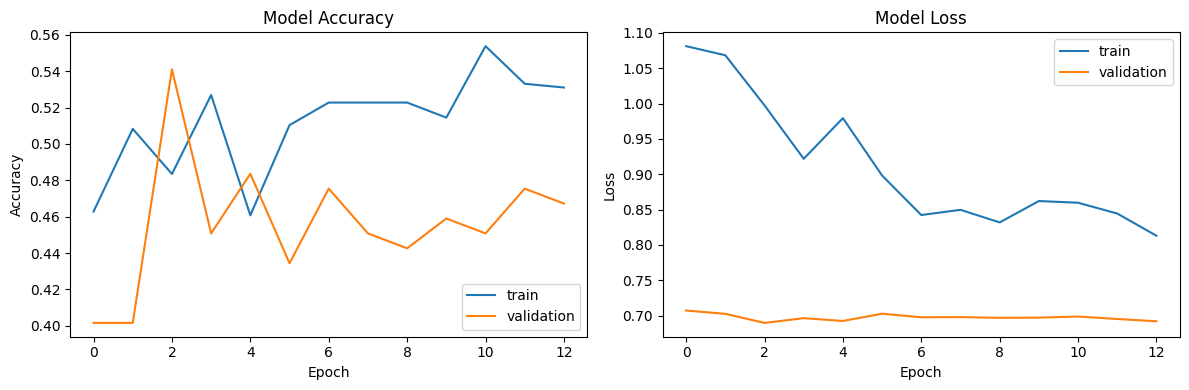

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5216 - auc_3: 0.5189 - loss: 0.6901 - precision_3: 0.4390 - recall_3: 0.6237


1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 905ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 318ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.47      0.55        73
           1       0.45      0.65      0.53        49

    accuracy                           0.54       122
   macro avg       0.56      0.56      0.54       122
weighted avg       0.58      0.54      0.54       122


Confusion Matrix:
[[34 39]
 [17 32]]


In [ ]:
class BalancedConvLSTMStressDetector:
    def __init__(self, base_dir="/content/drive/MyDrive/stress detection audio"):
        self.base_dir = base_dir
        self.sr = 22050
        self.duration = 2.0
        self.n_mels = 128
        self.time_steps = 32
        self.freq_bins = 32
        self.model = None

    def build_model(self, input_shape):
        """Revised model architecture with balanced learning"""
        inputs = Input(shape=input_shape)

        # First ConvLSTM block
        x = ConvLSTM2D(64, kernel_size=(3, 3),
                       padding='same',
                       return_sequences=True,
                       activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
        x = BatchNormalization()(x)
        x = MaxPooling3D(pool_size=(1, 2, 2))(x)
        x = Dropout(0.3)(x)

        # Second ConvLSTM block with residual connection
        residual = x
        x = ConvLSTM2D(128, kernel_size=(3, 3),
                       padding='same',
                       return_sequences=True,
                       activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = MaxPooling3D(pool_size=(1, 2, 2))(x)
        x = Dropout(0.4)(x)
        x = tf.keras.layers.Add()([x, residual])  # Add residual connection

        # Final ConvLSTM layer
        x = ConvLSTM2D(64, kernel_size=(3, 3),
                       padding='same',
                       return_sequences=False,
                       activation='relu',
                       kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        # Dense layers with skip connections
        x = Flatten()(x)

        dense1 = Dense(256, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        dense1 = BatchNormalization()(dense1)
        dense1 = Dropout(0.5)(dense1)

        dense2 = Dense(128, activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(dense1)
        dense2 = BatchNormalization()(dense2)
        dense2 = Dropout(0.4)(dense2)

        # Combine features from different levels
        combined = tf.keras.layers.Concatenate()([
            tf.keras.layers.GlobalAveragePooling2D()(x),
            dense2
        ])

        outputs = Dense(1, activation='sigmoid')(combined)

        return Model(inputs=inputs, outputs=outputs)

    def custom_loss(self):
        """Custom loss function with focal loss and class weighting"""
        def balanced_focal_loss(y_true, y_pred):
            gamma = 2.0  # Focal loss parameter
            alpha = 0.75  # Weight for positive class

            # Convert to float32
            y_true = tf.cast(y_true, tf.float32)
            y_pred = tf.cast(y_pred, tf.float32)

            # Calculate focal loss
            pt = tf.where(y_true == 1, y_pred, 1 - y_pred)
            focal_loss = -((1 - pt) ** gamma) * tf.math.log(pt + 1e-7)

            # Apply class weights
            weights = tf.where(y_true == 1, alpha, 1 - alpha)
            balanced_focal_loss = weights * focal_loss

            return tf.reduce_mean(balanced_focal_loss)
        return balanced_focal_loss

    def train(self, epochs=100, batch_size=32):
        """Enhanced training procedure with balanced sampling"""
        X, y = self.load_and_preprocess_data()

        # Create balanced dataset
        from sklearn.utils import resample

        # Separate majority and minority classes
        X_majority = X[y == 0]
        X_minority = X[y == 1]
        y_majority = y[y == 0]
        y_minority = y[y == 1]

        # Upsample minority class
        X_minority_upsampled, y_minority_upsampled = resample(
            X_minority, y_minority,
            replace=True,
            n_samples=len(X_majority),
            random_state=42
        )

        # Combine majority and upsampled minority
        X = np.vstack([X_majority, X_minority_upsampled])
        y = np.hstack([y_majority, y_minority_upsampled])

        # Shuffle the data
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X = X[indices]
        y = y[indices]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # Build and compile model
        self.model = self.build_model(X_train.shape[1:])

        # Custom learning rate schedule
        initial_learning_rate = 0.001
        decay_steps = 1000
        decay_rate = 0.9
        learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
            staircase=True
        )

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
            loss=self.custom_loss(),
            metrics=[
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')
            ]
        )

        # Enhanced callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_auc',  # Changed to AUC for better balance
                patience=20,
                restore_best_weights=True,
                mode='max'
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_auc',
                factor=0.2,
                patience=10,
                mode='max',
                min_lr=1e-6
            )
        ]

        # Train with class weights
        class_weights = {0: 1.0, 1: 2.0}  # Increased weight for minority class

        history = self.model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=callbacks,
            class_weight=class_weights
        )

        return history, X_test, y_test

# Usage remains the same
# Usage remains the same
def main():
    try:
        detector = ConvLSTMStressDetector()
        history, X_test, y_test = detector.train()

        # Plot training history
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='train')
        plt.plot(history.history['val_accuracy'], label='validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Evaluate model
        detector.evaluate(X_test, y_test)

    except Exception as e:
        print(f"Error in main: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

In [ ]:
##########################################Decision Tree and Logistic regression #############################################

## Decision Tree and Logistic regression

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import librosa
import os

class ClassicalMLStressDetector:
    def __init__(self, base_dir="/content/drive/MyDrive/stress detection audio"):
        self.base_dir = base_dir
        self.sr = 22050
        self.duration = 2.0
        self.scaler = StandardScaler()
        self.logistic_model = None
        self.decision_tree_model = None

    def extract_features(self, y, sr=22050):
        """Extract relevant features from audio signal"""
        if y is None or len(y) == 0:
            return None

        try:
            # Calculate target length
            target_length = int(sr * self.duration)

            # Pad or truncate the signal
            if len(y) > target_length:
                y = y[:target_length]
            else:
                y = np.pad(y, (0, max(0, target_length - len(y))))

            # Extract features
            features = []

            # MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            features.extend(np.mean(mfccs.T, axis=0))
            features.extend(np.std(mfccs.T, axis=0))

            # Spectral Features
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            features.extend([np.mean(spectral_centroids), np.std(spectral_centroids)])

            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
            features.extend([np.mean(spectral_rolloff), np.std(spectral_rolloff)])

            # Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            features.extend([np.mean(zcr), np.std(zcr)])

            # RMS Energy
            rms = librosa.feature.rms(y=y)[0]
            features.extend([np.mean(rms), np.std(rms)])

            return np.array(features)

        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return None

    def load_data(self):
        """Load and preprocess the audio data"""
        features_list = []
        labels = []

        # Define emotion to stress mapping
        emotion_map = {
            'anger': 1,     # stressed
            'fear': 1,      # stressed
            'disgust': 0,   # not stressed
            'happiness': 0, # not stressed
            'sadness': 0    # not stressed
        }

        for emotion in emotion_map.keys():
            folder_path = os.path.join(self.base_dir, emotion)
            if os.path.exists(folder_path):
                print(f"Processing {emotion} files...")
                for file in os.listdir(folder_path):
                    if file.endswith('.wav'):
                        try:
                            file_path = os.path.join(folder_path, file)
                            y, sr = librosa.load(file_path, duration=self.duration)
                            features = self.extract_features(y, sr)

                            if features is not None:
                                features_list.append(features)
                                labels.append(emotion_map[emotion])
                        except Exception as e:
                            print(f"Error processing {file}: {str(e)}")
                            continue

        return np.array(features_list), np.array(labels)

    def train_logistic_regression(self, X, y):
        """Train Logistic Regression model"""
        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        # Initialize and train model
        self.logistic_model = LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        )

        self.logistic_model.fit(X_train, y_train)

        # Evaluate model
        train_score = self.logistic_model.score(X_train, y_train)
        test_score = self.logistic_model.score(X_test, y_test)

        print("\nLogistic Regression Results:")
        print(f"Training accuracy: {train_score:.3f}")
        print(f"Testing accuracy: {test_score:.3f}")

        # Detailed evaluation
        y_pred = self.logistic_model.predict(X_test)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        return self.logistic_model

    def train_decision_tree(self, X, y):
        """Train Decision Tree model"""
        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        # Initialize and train model
        self.decision_tree_model = DecisionTreeClassifier(
            class_weight='balanced',
            max_depth=5,
            min_samples_split=10,
            random_state=42
        )

        self.decision_tree_model.fit(X_train, y_train)

        # Evaluate model
        train_score = self.decision_tree_model.score(X_train, y_train)
        test_score = self.decision_tree_model.score(X_test, y_test)

        print("\nDecision Tree Results:")
        print(f"Training accuracy: {train_score:.3f}")
        print(f"Testing accuracy: {test_score:.3f}")

        # Detailed evaluation
        y_pred = self.decision_tree_model.predict(X_test)
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        # Feature importance
        feature_importance = pd.DataFrame({
            'feature': range(X.shape[1]),
            'importance': self.decision_tree_model.feature_importances_
        })
        print("\nTop 5 Most Important Features:")
        print(feature_importance.nlargest(5, 'importance'))

        return self.decision_tree_model

    def predict(self, audio_path, model_type='logistic'):
        """Predict stress level for new audio"""
        try:
            # Load and extract features
            y, sr = librosa.load(audio_path, duration=self.duration)
            features = self.extract_features(y, sr)

            if features is None:
                return None

            # Scale features
            features_scaled = self.scaler.transform(features.reshape(1, -1))

            # Make prediction
            if model_type == 'logistic' and self.logistic_model is not None:
                prediction = self.logistic_model.predict(features_scaled)
                probability = self.logistic_model.predict_proba(features_scaled)[0]
            elif model_type == 'decision_tree' and self.decision_tree_model is not None:
                prediction = self.decision_tree_model.predict(features_scaled)
                probability = self.decision_tree_model.predict_proba(features_scaled)[0]
            else:
                raise ValueError("Invalid model type or model not trained")

            return {
                'prediction': 'stressed' if prediction[0] == 1 else 'not_stressed',
                'probability': probability.max()
            }

        except Exception as e:
            print(f"Error making prediction: {str(e)}")
            return None

def main():
    # Initialize detector
    detector = ClassicalMLStressDetector()

    # Load data
    print("Loading and extracting features from audio files...")
    X, y = detector.load_data()

    # Train both models
    print("\nTraining Logistic Regression...")
    detector.train_logistic_regression(X, y)

    print("\nTraining Decision Tree...")
    detector.train_decision_tree(X, y)

if __name__ == "__main__":
    main()

Loading and extracting features from audio files...
Processing anger files...
Processing fear files...
Processing disgust files...
Processing happiness files...
Processing sadness files...


<ipython-input-1-5ecca1d6a7fd>:86: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, duration=self.duration)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing s05 (3).wav: 

Training Logistic Regression...

Logistic Regression Results:
Training accuracy: 0.705
Testing accuracy: 0.721

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        73
           1       0.63      0.76      0.69        49

    accuracy                           0.72       122
   macro avg       0.72      0.73      0.72       122
weighted avg       0.74      0.72      0.72       122


Confusion Matrix:
[[51 22]
 [12 37]]

Training Decision Tree...

Decision Tree Results:
Training accuracy: 0.804
Testing accuracy: 0.639

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        73
           1       0.55      0.61      0.58        49

    accuracy                           0.64       122
   macro avg       0.63      0.63      0.63       122
weighted avg       0.65      0.64      0.64       122


Confusion Matrix

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import librosa
import os
import warnings
warnings.filterwarnings('ignore')

class SimpleStressDetector:
    def __init__(self, base_dir="/content/drive/MyDrive/stress detection audio"):
        self.base_dir = base_dir
        self.sr = 22050
        self.duration = 2.0
        self.scaler = StandardScaler()
        self.logistic_model = None
        self.decision_tree_model = None

    def extract_features(self, y, sr=22050):
        """Extract a simplified set of features from audio signal"""
        try:
            # Ensure consistent length
            target_length = int(sr * self.duration)
            if len(y) > target_length:
                y = y[:target_length]
            else:
                y = np.pad(y, (0, max(0, target_length - len(y))))

            # Initialize feature array
            features = []

            # Extract MFCC features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_means = np.mean(mfccs, axis=1)
            mfcc_stds = np.std(mfccs, axis=1)
            features = np.concatenate([mfcc_means, mfcc_stds])

            # Handle any NaN or infinite values
            features = np.nan_to_num(features)

            return features.flatten()

        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return None

    def load_data(self):
        """Load and preprocess the audio data"""
        features_list = []
        labels = []

        emotion_map = {
            'anger': 1,     # stressed
            'fear': 1,      # stressed
            'disgust': 0,   # not stressed
            'happiness': 0, # not stressed
            'sadness': 0    # not stressed
        }

        for emotion in emotion_map.keys():
            folder_path = os.path.join(self.base_dir, emotion)
            if os.path.exists(folder_path):
                print(f"Processing {emotion} files...")
                for file in os.listdir(folder_path):
                    if file.endswith('.wav'):
                        try:
                            file_path = os.path.join(folder_path, file)
                            y, sr = librosa.load(file_path, duration=self.duration)
                            features = self.extract_features(y, sr)

                            if features is not None:
                                features_list.append(features)
                                labels.append(emotion_map[emotion])
                        except Exception as e:
                            print(f"Error processing {file}: {str(e)}")
                            continue

        if not features_list:
            raise ValueError("No features could be extracted from the audio files")

        return np.array(features_list), np.array(labels)

    def train_logistic_regression(self, X, y):
        """Train Logistic Regression model"""
        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        # Define parameters for grid search
        param_grid = {
            'C': [0.1, 1, 10],
            'class_weight': ['balanced', None]
        }

        # Perform grid search
        grid_search = GridSearchCV(
            LogisticRegression(max_iter=1000),
            param_grid,
            cv=5,
            scoring='f1',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        self.logistic_model = grid_search.best_estimator_

        # Evaluate model
        y_pred = self.logistic_model.predict(X_test)

        print("\nLogistic Regression Results:")
        print(f"Best parameters: {grid_search.best_params_}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        return self.logistic_model

    def train_decision_tree(self, X, y):
        """Train Decision Tree model"""
        # Scale features
        X_scaled = self.scaler.transform(X)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        # Define parameters for grid search
        param_grid = {
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5],
            'class_weight': ['balanced', None]
        }

        # Perform grid search
        grid_search = GridSearchCV(
            DecisionTreeClassifier(),
            param_grid,
            cv=5,
            scoring='f1',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        self.decision_tree_model = grid_search.best_estimator_

        # Evaluate model
        y_pred = self.decision_tree_model.predict(X_test)

        print("\nDecision Tree Results:")
        print(f"Best parameters: {grid_search.best_params_}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

        return self.decision_tree_model

def main():
    # Initialize detector
    detector = SimpleStressDetector()

    # Load data
    print("Loading and extracting features from audio files...")
    X, y = detector.load_data()

    # Train models
    print("\nTraining Logistic Regression...")
    detector.train_logistic_regression(X, y)

    print("\nTraining Decision Tree...")
    detector.train_decision_tree(X, y)

if __name__ == "__main__":
    main()

Loading and extracting features from audio files...
Processing anger files...
Processing fear files...
Processing disgust files...
Processing happiness files...
Processing sadness files...
Error processing s05 (3).wav: 

Training Logistic Regression...

Logistic Regression Results:
Best parameters: {'C': 1, 'class_weight': 'balanced'}

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.75        73
           1       0.63      0.69      0.66        49

    accuracy                           0.71       122
   macro avg       0.70      0.71      0.71       122
weighted avg       0.72      0.71      0.71       122


Confusion Matrix:
[[53 20]
 [15 34]]

Training Decision Tree...

Decision Tree Results:
Best parameters: {'class_weight': 'balanced', 'max_depth': 7, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.70      0.71        73
    

## Logistic Regression
## Random Forest Classifier
## Ensemble Voting Classifier

Loading and extracting features from audio files...
Processing anger files...
Processing fear files...
Processing disgust files...
Processing happiness files...
Processing sadness files...
Error processing s05 (3).wav: 

Logistic Regression Results:
Best parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 1000}
Cross-validation scores: mean=0.601 (+/- 0.055)

Random Forest Results:
Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 200}
Cross-validation scores: mean=0.581 (+/- 0.062)


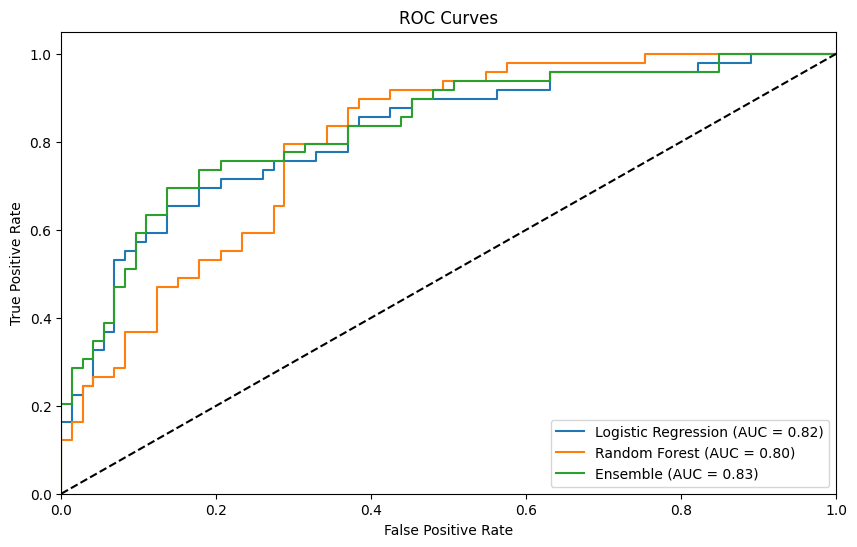


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.71      0.76        73
           1       0.64      0.76      0.69        49

    accuracy                           0.73       122
   macro avg       0.73      0.73      0.73       122
weighted avg       0.74      0.73      0.73       122



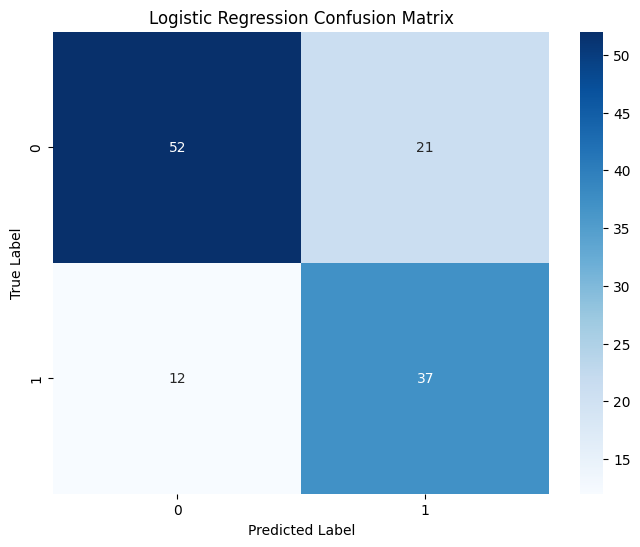


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        73
           1       0.61      0.63      0.62        49

    accuracy                           0.69       122
   macro avg       0.68      0.68      0.68       122
weighted avg       0.69      0.69      0.69       122



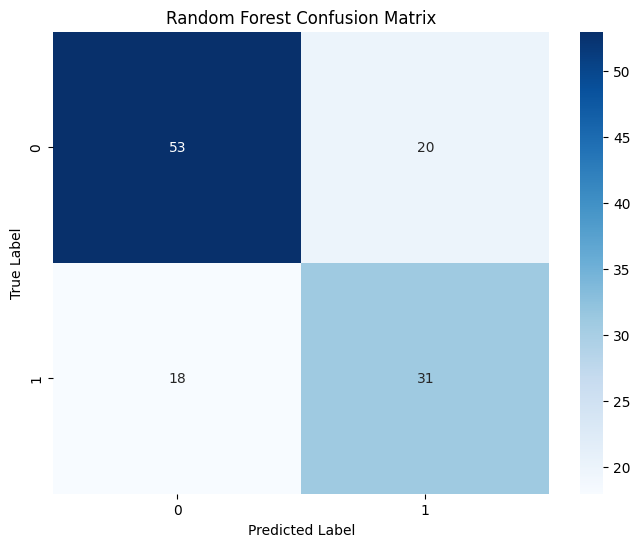


Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.73      0.77        73
           1       0.65      0.76      0.70        49

    accuracy                           0.74       122
   macro avg       0.73      0.74      0.73       122
weighted avg       0.75      0.74      0.74       122



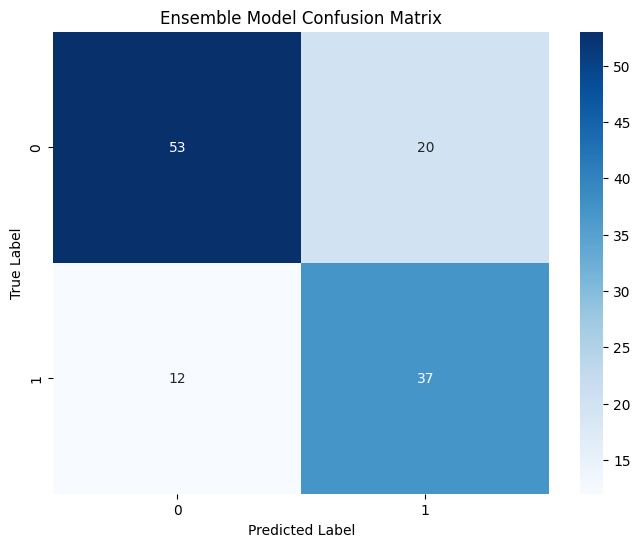

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

class ImprovedStressDetector:
    def __init__(self, base_dir="/content/drive/MyDrive/stress detection audio"):
        self.base_dir = base_dir
        self.sr = 22050
        self.duration = 2.0
        self.scaler = StandardScaler()
        self.models = {}
        self.ensemble_model = None

    def extract_features(self, y, sr=22050):
        """Extract enhanced feature set from audio signal"""
        try:
            # Ensure consistent length
            target_length = int(sr * self.duration)
            if len(y) > target_length:
                y = y[:target_length]
            else:
                y = np.pad(y, (0, max(0, target_length - len(y))))

            features = []

            # MFCC features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfcc_means = np.mean(mfccs, axis=1)
            mfcc_stds = np.std(mfccs, axis=1)
            features.extend(mfcc_means)
            features.extend(mfcc_stds)

            # Spectral Features
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            features.append(np.mean(spectral_centroids))
            features.append(np.std(spectral_centroids))

            # Zero Crossing Rate
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            features.append(np.mean(zcr))
            features.append(np.std(zcr))

            # Energy features
            rms = librosa.feature.rms(y=y)[0]
            features.append(np.mean(rms))
            features.append(np.std(rms))

            features = np.array(features)
            features = np.nan_to_num(features)  # Handle any NaN values

            return features

        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return None

    def plot_roc_curves(self, X_test, y_test):
        """Plot ROC curves for all models"""
        plt.figure(figsize=(10, 6))

        for name, model in self.models.items():
            y_pred_proba = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

        # Add ensemble model ROC curve
        if self.ensemble_model is not None:
            y_pred_proba = self.ensemble_model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Ensemble (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc="lower right")
        plt.show()

    def load_data(self):
        """Load and preprocess the audio data"""
        features_list = []
        labels = []
        filenames = []

        emotion_map = {
            'anger': 1,     # stressed
            'fear': 1,      # stressed
            'disgust': 0,   # not stressed
            'happiness': 0, # not stressed
            'sadness': 0    # not stressed
        }

        for emotion in emotion_map.keys():
            folder_path = os.path.join(self.base_dir, emotion)
            if os.path.exists(folder_path):
                print(f"Processing {emotion} files...")
                for file in os.listdir(folder_path):
                    if file.endswith('.wav'):
                        try:
                            file_path = os.path.join(folder_path, file)
                            y, sr = librosa.load(file_path, duration=self.duration)
                            features = self.extract_features(y, sr)

                            if features is not None:
                                features_list.append(features)
                                labels.append(emotion_map[emotion])
                                filenames.append(file)
                        except Exception as e:
                            print(f"Error processing {file}: {str(e)}")
                            continue

        return np.array(features_list), np.array(labels), filenames

    def train_models(self, X, y):
        """Train multiple models and create an ensemble"""
        # Scale features
        X_scaled = self.scaler.fit_transform(X)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )

        # Train Logistic Regression
        lr_params = {
            'C': [0.1, 1, 10],
            'class_weight': ['balanced'],
            'max_iter': [1000]
        }
        lr = self._train_model(LogisticRegression(), lr_params, X_train, y_train, "Logistic Regression")

        # Train Random Forest
        rf_params = {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, 10],
            'class_weight': ['balanced']
        }
        rf = self._train_model(RandomForestClassifier(), rf_params, X_train, y_train, "Random Forest")

        # Create Voting Classifier
        self.ensemble_model = VotingClassifier(
            estimators=[
                ('lr', lr),
                ('rf', rf)
            ],
            voting='soft'
        )

        # Train ensemble
        self.ensemble_model.fit(X_train, y_train)

        # Evaluate all models
        self._evaluate_models(X_test, y_test)

        return X_test, y_test

    def _train_model(self, model, params, X_train, y_train, name):
        """Helper function to train individual models"""
        grid_search = GridSearchCV(
            model, params, cv=5, scoring='f1', n_jobs=-1
        )
        grid_search.fit(X_train, y_train)
        self.models[name] = grid_search.best_estimator_

        # Perform cross-validation
        cv_scores = cross_val_score(
            grid_search.best_estimator_, X_train, y_train, cv=5, scoring='f1'
        )

        print(f"\n{name} Results:")
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Cross-validation scores: mean={cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

        return grid_search.best_estimator_

    def _evaluate_models(self, X_test, y_test):
        """Evaluate all models and create performance visualizations"""
        # Plot ROC curves
        self.plot_roc_curves(X_test, y_test)

        for name, model in self.models.items():
            # Predictions and metrics
            y_pred = model.predict(X_test)
            print(f"\n{name} Classification Report:")
            print(classification_report(y_test, y_pred))

            # Confusion Matrix
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{name} Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()

        # Evaluate ensemble
        y_pred_ensemble = self.ensemble_model.predict(X_test)
        print("\nEnsemble Model Classification Report:")
        print(classification_report(y_test, y_pred_ensemble))

        # Ensemble Confusion Matrix
        plt.figure(figsize=(8, 6))
        cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
        sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues')
        plt.title('Ensemble Model Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    def predict(self, audio_path):
        """Make predictions on new audio files"""
        try:
            y, sr = librosa.load(audio_path, duration=self.duration)
            features = self.extract_features(y, sr)

            if features is not None:
                features_scaled = self.scaler.transform(features.reshape(1, -1))

                # Get predictions from all models
                predictions = {}
                probabilities = {}

                for name, model in self.models.items():
                    pred = model.predict(features_scaled)
                    prob = model.predict_proba(features_scaled)
                    predictions[name] = 'stressed' if pred[0] == 1 else 'not stressed'
                    probabilities[name] = prob[0][1]  # Probability of being stressed

                # Ensemble prediction
                ensemble_pred = self.ensemble_model.predict(features_scaled)
                ensemble_prob = self.ensemble_model.predict_proba(features_scaled)
                predictions['Ensemble'] = 'stressed' if ensemble_pred[0] == 1 else 'not stressed'
                probabilities['Ensemble'] = ensemble_prob[0][1]
                return predictions, probabilities

        except Exception as e:
            print(f"Error predicting for {audio_path}: {str(e)}")
            return None, None

def main():
    # Initialize detector
    detector = ImprovedStressDetector()

    # Load data
    print("Loading and extracting features from audio files...")
    X, y, filenames = detector.load_data()

    # Train and evaluate models
    X_test, y_test = detector.train_models(X, y)

if __name__ == "__main__":
    main()